# Банки — Сегментация пользователей по потреблению


## Задача

- Проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов.
- На основании поведения клиентов определить вероятность их ухода и предложить меры по удержанию клиентов (предложение релевантного банковского продукта).
- Проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

## Описание данных
Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.
Колонки:
- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

## Предобработка данных 


In [1]:
! pip install phik

In [2]:
import pandas as pd     # Импортируем необходимые библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings # отключили предупреждения          #
warnings.filterwarnings('ignore')                   #

from scipy import stats as st  # для статистики

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

In [3]:
data = pd.read_csv('bank_dataset.csv')  # Считываем данные из файла
data.info()                                       # Смотрим имеющуюся информацию
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Имеем датафрейм на 10 000 строк. Этого достаточно, чтобы пытаться находить какие-либо закономерности.

### Наименования колонок
Видим, что для корректности наименований колонок достаточно переименовать их в соответствии с правилами хорошего стиля, заменив на нижний регистр. 

In [4]:
data.columns = data.columns.str.lower()  # использовали метод df.columns.str.lower
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Типы данных
Посмотрим на соответствие типов. Вообще все типы соответствуют своим целям. Можно было бы применить тип boolean для столбцов creditcard и churn, но и значения 0 и 1 как integer вполне подходят.

Выведем информацию об основных статистических характеристиках данных: минимальные, максимальные, средние значения, стандартные отклонения. Воспользуемся методом describe().

In [5]:
pd.set_option('display.float_format', '{:.2f}'.format)  # Все числа float в таблице будут отражаться с 2 знаками после запятой

data.describe().T  # транспонировали для удобства восприятия таблицы

,count,mean,std,min,25%,50%,75%,max
userid,10000.00,15733676.57,71936.19,15608437.00,15671264.25,15733474.00,15795969.75,15858426.00
score,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
objects,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
balance,6383.00,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
products,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
creditcard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48
churn,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00


Видим, что значения корректны, находятся в пределах разумного, creditcard и churn принимают значения только 0 и 1, значения активности (loyalty) тоже 0 и 1.

Число продуктов, которыми пользуются клиенты банка, колеблется в пределах от 1 до 4.

### Дубликаты
Исследуем дубликаты. Удалим их, если необходимо.

In [6]:
print('Количество дубликатов в таблице:', data.duplicated().sum())
print('Количество уникальных пользователей (клиентов):', data['userid'].nunique())

Количество дубликатов в таблице: 0
Количество уникальных пользователей (клиентов): 10000


### Пропущенные значения   
Исследуем пропущенные значения. Уточним, что они означают, если есть такая информация. Решим, стоит ли заменить их при возможности. 

Пропуски есть только в столбце balance — баланс на счёте, причем это только дебетовый баланс (по информации от тимлида). Возможно, это только те клиенты, которые имеют только кредитные карты. Или те, кто уже ушел из банка. Проверим гипотезы. Выведем информацию только по клиентам с пропущенным балансом. 

In [7]:
print('Пропусков баланса:', data.loc[np.isnan(data['balance'])].shape[0])   

Пропусков баланса: 3617


Пропусков слишком много (треть от общего количества), чтобы можно было просто удалить их.

In [8]:
data.loc[np.isnan(data['balance'])].head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0


Обе гипотезы оказались ложными. Даже в первых строках есть те, у кого нет кредитной карты, и те, кто не ушел из банка. Предположение, что система просто не успела отработать и проставить "1" для ушедших даже не рассматривается ввиду слишком большого числа клиентов с NaN.

Еще раз посмотрим на статистические данные. 

In [9]:
data.loc[np.isnan(data['balance'])].describe().T  # Статистика по пользователям с пропущенным балансом

,count,mean,std,min,25%,50%,75%,max
userid,3617.00,15734685.59,71947.49,15608442.00,15672255.00,15736083.00,15796286.00,15858100.00
score,3617.00,649.45,96.16,350.00,583.00,651.00,717.00,850.00
age,3617.00,38.43,10.49,18.00,31.00,37.00,43.00,88.00
objects,3617.00,5.07,2.86,0.00,3.00,5.00,7.00,10.00
balance,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products,3617.00,1.78,0.50,1.00,1.00,2.00,2.00,4.00
creditcard,3617.00,0.72,0.45,0.00,0.00,1.00,1.00,1.00
loyalty,3617.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,3617.00,98983.56,57730.83,90.07,49506.82,98618.79,148330.97,199992.48
churn,3617.00,0.14,0.35,0.00,0.00,0.00,0.00,1.00


Посмотрим статистику отдельно по тем пользователям, у которых баланс указан, сравним с предыдущей и попробуем выяснить закономерности.

In [10]:
data.dropna().describe().T  

,count,mean,std,min,25%,50%,75%,max
userid,6383.00,15733104.80,71929.13,15608437.00,15670940.00,15732262.00,15795842.00,15858426.00
score,6383.00,651.14,96.93,350.00,584.00,652.00,718.00,850.00
age,6383.00,39.20,10.48,18.00,32.00,38.00,44.00,92.00
objects,6383.00,4.98,2.91,0.00,2.00,5.00,8.00,10.00
balance,6383.00,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
products,6383.00,1.39,0.58,1.00,1.00,1.00,2.00,4.00
creditcard,6383.00,0.70,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,6383.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,6383.00,100717.35,57380.32,11.58,51736.85,101139.30,149596.61,199970.74
churn,6383.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


Немного отличаются медианное значение и стандартное отклонение для количества продуктов и оттока, ну и можно посмотреть, скажем, наличие кредитки. Поподробнее рассмотрим их и не попавшие в describe() столбцы с текстовыми (object) значениями - пол и город.  Для удобства создадим столбец 'tick_balance' со значениями 0 - баланс не указан (NaN) и 1 - баланс указан.

In [11]:
data['tick_balance'] = 1                                 # Создали столбец, где всем значениям присвоили 1
data['tick_balance'].loc[np.isnan(data['balance'])] = 0  # Переприсвоили 0 там, где баланс NaN
data.head()                                              # Смотрим, что получилось

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,tick_balance
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,1
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,1


### Функция для вывода гистограмм

Опишем функцию для вывода гистограмм по какому-либо признаку с делением по еще одному признаку. Это пригодится и в дальнейшем.

In [12]:
def my_displot(df, column_, hue_=None, bin_s=10, title=None, xlabel=None, ylabel=None):
    sns.displot(
        x=column_,
        hue=hue_,       # разбивка цветом по дополнительному признаку
        bins = bin_s,
        multiple='stack',  # накопительные
        data=df
    )
            
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)    
    #plt.show()   

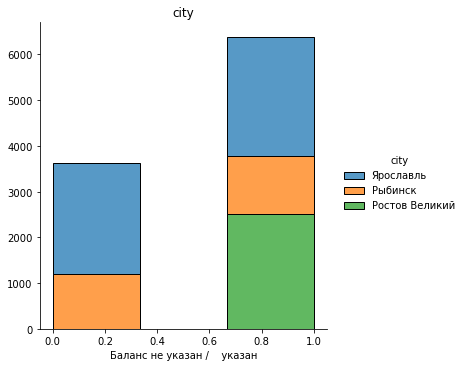

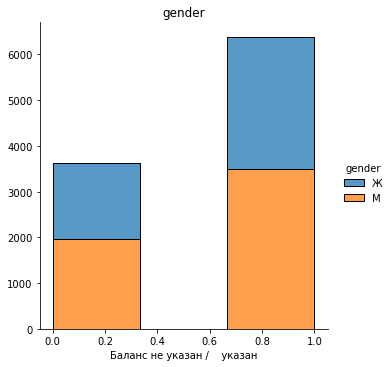

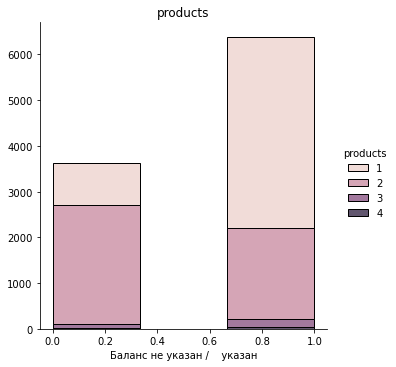

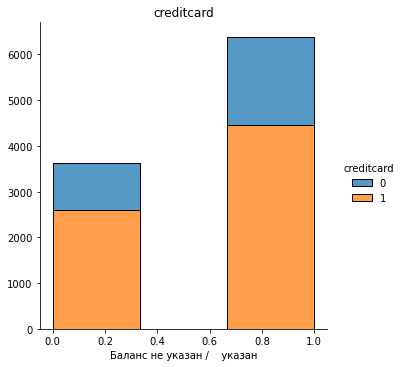

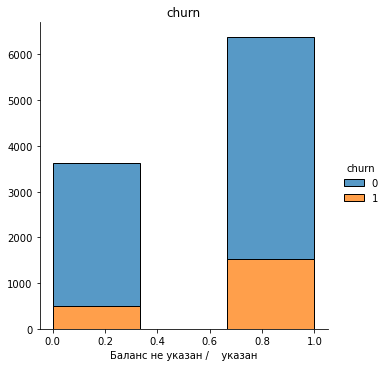

In [13]:
# Создадим список признаков, интересующих в плане отсутствия баланса:
feature_list = ['city', 'gender', 'products', 'creditcard', 'churn']  

# В цикле вызовем построение гистограмм с разбивкой по признаку:
for feature in feature_list:
    my_displot(data, 
               'tick_balance', # Построение гистограммы в два столбца "нет баланса" - "баланс указан"
               feature,        # Дополнительный признак 
               bin_s=3, 
               title=feature, # Заголовок - название признака
               xlabel='Баланс не указан /    указан')

Самый первый график дает интересный результат, в г. Ростов Великий всегда указан баланс на счете, а в двух других городах примерно в половине случаев он не указывается. По-видимому, не указанный баланс как-то связан с отделением банка, причем в Ростове Великом это поле является обязательным для заполнения, а в двух других городах - нет.

Еще можно заметить, что для клиентов с одним банковским продуктом баланс указан примерно в 80% случаев, а у тех, у кого их два, он чаще не указывается. Выдвинем гипотезу, что возможные пропуски могут быть связаны со сложностями подсчета в зависимости от количества видов продукта, которым пользуется клиент. Тогда в Ростове картина по их количеству будет отличаться (скажем, у всех только один продукт).

Посмотрим, как распределено количество продуктов для Ростова, и есть ли там кредитные карты.

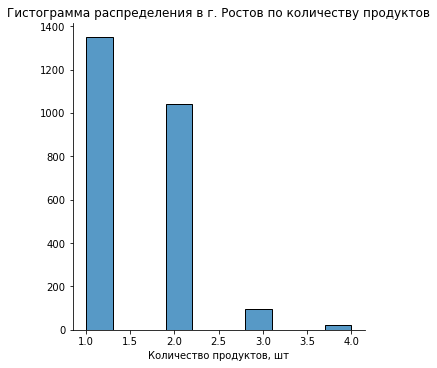

In [14]:
my_displot(data.query('city == "Ростов Великий"'), 
           'products',        
                    # Дополнительный признак отсутствует 
            # bin_s не указываем 
            title='Гистограмма распределения в г. Ростов по количеству продуктов',
            xlabel='Количество продуктов, шт')

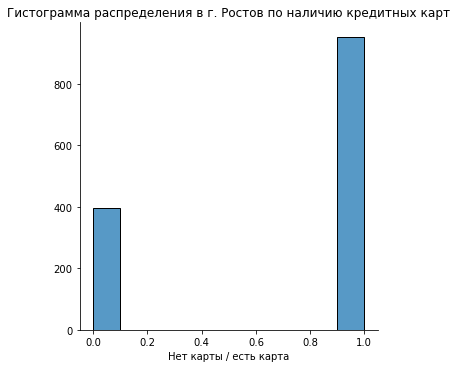

In [15]:
my_displot(data.query('city == "Ростов Великий" & products == 1'), # Ростов и только один продукт - предполагаемая кредитка
           'creditcard',        
                    # Дополнительный признак отсутствует 
                    # bin_s не указываем 
            title='Гистограмма распределения в г. Ростов по наличию кредитных карт',
            xlabel='Нет карты / есть карта')

Ничего особенного не выявлено, значит, количество продуктов или наличие только кредитной карты никак не влияет на подсчет баланса, и версия о сложностях подсчета при нескольких банковских продуктах не нашла поддержку. 

### Вывод по пропускам 
Не указанный баланс зависит от того, каким отделением банка предоставлялись данные. Отделения в г. Ростов Великий данные предоставили полностью, в двух других городах примерно в каждом втором случае баланс по каким-либо неизвестным на данный момент причинам в базу данных не попал (можно предположить, скорее, техническую ошибку, но можно и банковскую политику отдельных отделений банка).

Так как для дальнейших целей анализа в этот раз нам не потребуются данные по балансу (нас интересует количество используемых банковских продуктов и возможность удержать клиента вне зависимости от баланса его денежных средств), пропуски заполнять не будем. Включать в анализ дополнительный столбец "tick_balance" так же не станем.


## Исследовательский анализ данных

Сегментация пользователей на основе данных о количестве потребляемых продуктов. Цель исследования: на основании сегментации определить вероятность их ухода.

### Сегментация (категоризация) пользователей по количеству используемых банковских продуктов

На основе значений столбца Products нужно разделить клиентов на N категорий. Как мы уже видели, количество продуктов колеблется от 1 до 4. Посмотрим, как клиенты распределены по числу продуктов. Построим столбчатую гистограмму.

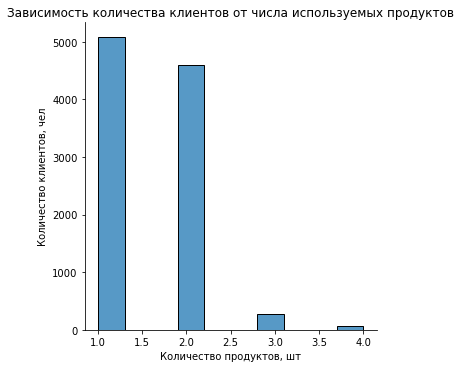

In [16]:
# используем определенную выше функцию
my_displot(data,          
           'products',        
                    # Дополнительный признак отсутствует 
                    # bin_s не указываем 
            title='Зависимость количества клиентов от числа используемых продуктов', # Заголовок 
            xlabel='Количество продуктов, шт',
            ylabel='Количество клиентов, чел'
          )

Выделяется три сегмента: с одним банковским продуктом, с двумя и малочисленный сегмент 3 или 4 продукта. Добавим к нашему датафрейму столбец "категория", разбив клиентов на категории "1", "2" и "3", включив в последнюю тех, у кого используются 3 и более продуктов.

In [17]:
cat = {1: 1, 2: 2, 3: 3, 4: 3}  # Создали словарь, где ключ - кол-во продуктов, значения - категория

data['category'] = data['products'].replace(cat)  # Категоризируем с помощью replace, создав новый столбец 'category'


### Проверка влияния категории клиента на вероятность ухода


#### Определим зависимость категории и вероятности ухода

Внутри каждой категории посмотрим на процент ушедших (столбец Churn). Представим в виде гистограммы с разбивкой цветом.

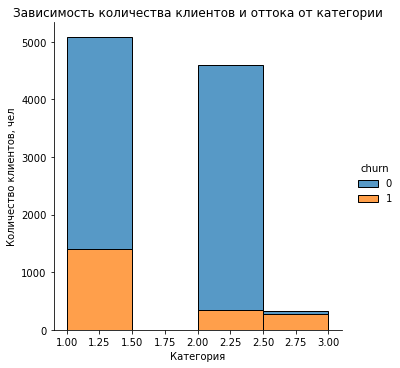

In [18]:
my_displot(data,         
           'category',        
           'churn',         # Дополнительный признак 
            bin_s=4, 
            title='Зависимость количества клиентов и оттока от категории',  
            xlabel='Категория',
            ylabel='Количество клиентов, чел'
          )

Наиболее подвержена уходу третья категория (3-4 банковских продукта). Также высока доля уходящих (больше четверти) в первой категории (только один продукт).

In [19]:
print('Размер третьей группы:', len(data.query('category == 3')))

Размер третьей группы: 326


От 10 000 клиентов, описанных в данных, это лишь чуть больше 3%. Не очень показательно в целом, но имеет право быть отнесено к отдельной категории, так как в этой группе очень высокий отток клиентов.

#### Внутри каждой категории определим дополнительные показатели и создадим матрицы корреляций

Как мы выяснили, баланс на счете в нашем случае не является показателем ввиду большого числа пропусков. Поэтому выделим остальные признаки, которые могут оказаться показательными при имеющейся сегментации. Это будут: наличие кредитной карты, активность, количество объектов в собственности, город, пол, возраст, баллы кредитного скоринга и оцененная зарплата. Запишем их в переменной characteristic.

Создадим матрицы корреляций для выделенных сегментов и визуализируем их в виде тепловых карт. На их основе посмотрим, есть ли взаимосвязь дополнительных показателей и группы сегментации.

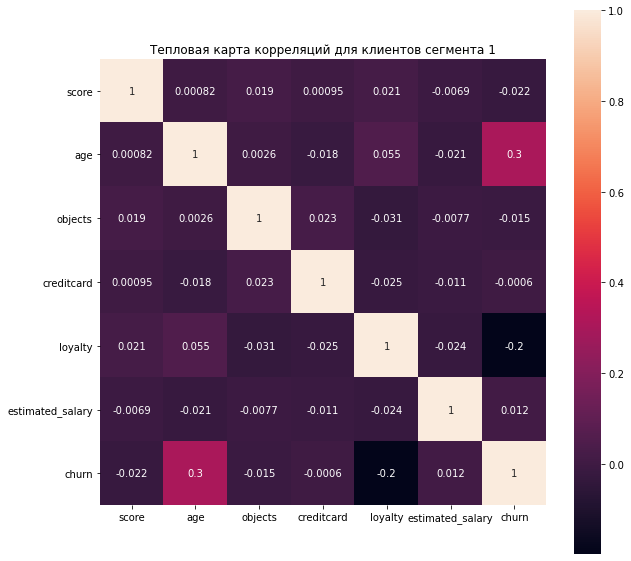

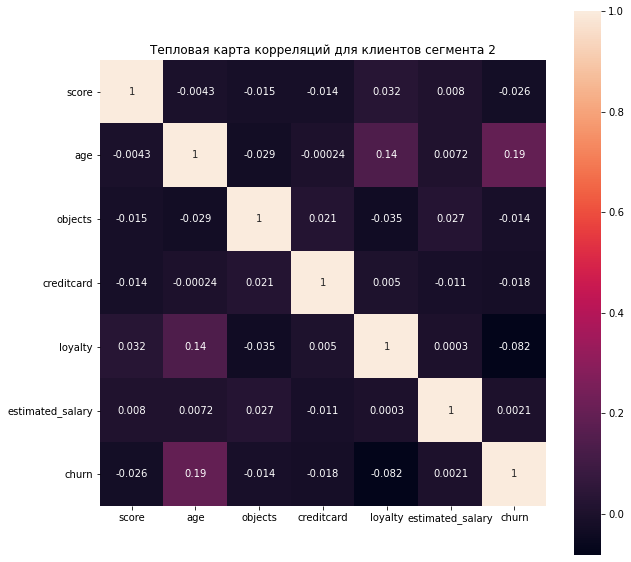

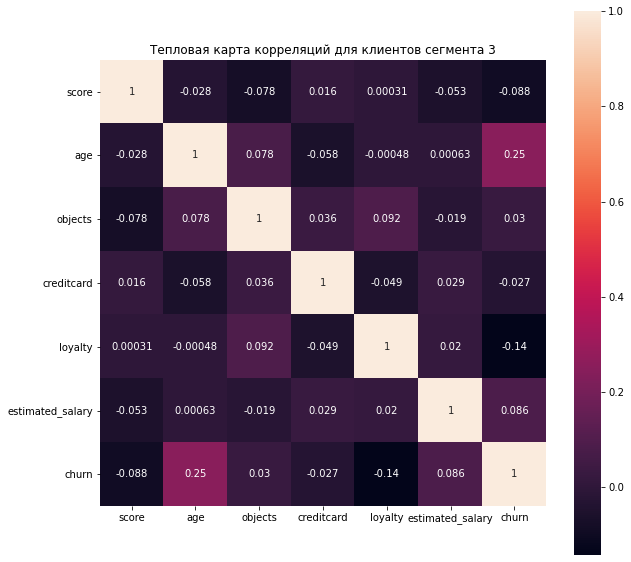

In [20]:
characteristic = ['score', 'city', 'gender', 'age', 'objects', 'creditcard', 'loyalty', 'estimated_salary', 'churn']
for n in range(1, 4):

    cm = data.query('category == @n')[characteristic].corr() # вычисляем матрицу корреляций
    plt.figure(figsize=(10, 10))

    sns.heatmap(cm, annot=True, square=True) # тепловая карта с подписями для матрицы корреляций 
    plt.title('Тепловая карта корреляций для клиентов сегмента '+ str(n))
    plt.show()


   
**Выводы на основе матриц корреляции** 

- В первом сегменте (1 банковский продукт) есть незначительная корреляция лояльности (активности) и возраста, а также наличия кредитной карты и объектов в собственности (что логично при кредитах, но не связано с оттоком). Наибольшая корреляция наблюдается у возраста и оттока - 0,3.

- Во втором сегменте (2 продукта) также есть незначительная корреляция лояльности и возраста. Корреляция возраста и ухода - 0,19.

- В третьем сегменте слабые корреляции количества объектов и возраста, лояльности и количества объектов, но эти данные нам ни о чем не говорят. Также есть слабая корреляция предполагаемого уровня доходов и оттока. Так как уровень дохода всего лишь предполагаемый, эти данные можно не учитывать. Как и в предыдущих сегментах наиболее ярко выражена корреляция возраста и ухода - 0,25.


- В первом и третьем сегменте лояльность (активность) и отток обратно коррелируют друг с другом, значения отрицательные: -0,2 и -0,14. Это означает, что при росте одного другое уменьшается, то есть увеличение активности уменьшает вероятность скорого ухода, и наоборот. 

Хотя для большинства клиентов наблюдается взаимосвязь возраста и активности, непосредственно активность не связана с оттоком, рассматривать ее не будем.

Как ни странно, матрицы показывают, что score — баллы кредитного скоринга, никак не коррелируют с оттоком. На их основе невозможно предсказать поведение клиента. 


Столбцы 'city' и 'gender' не попали в обычную матрицу корреляций. Категоризируем эти признаки.


In [21]:
data_new = pd.get_dummies(data, columns=['gender', 'city'])  # применили унитарное кодирование (One Hot Encoding)
data_new.head()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,tick_balance,category,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,42,2,NaN,1,1,1,101348.88,1,0,1,1,0,0,0,1
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,1,1,1,0,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,1,3,1,0,0,0,1
3,15744090,699,39,1,NaN,2,0,0,93826.63,0,0,2,1,0,0,0,1
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,1,1,1,0,0,1,0


Еще раз создадим набор столбцов, включающий категории городов и пола. Затем воспользуемся библиотекой phik. Найдем глобальную корреляцию признаков и матрицу корреляций.

In [22]:
df=data_new.drop(columns=['userid', 'balance', 'tick_balance', 'category']) 
              # Создали новый датафрейм для удобства без трех столбцов, не требующихся для анализа

interval columns not set, guessing: ['score', 'age', 'objects', 'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn', 'gender_Ж', 'gender_М', 'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль']


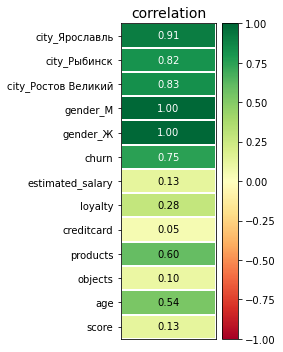

In [23]:
# Глобальная корреляция, выражающая общую корреляцию одной переменной со всеми другими переменными в наборе данных
global_correlation, global_labels = df.global_phik() 

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels,
                        figsize=(4, 5)
                       )
plt.tight_layout()

Как видим, наибольшая корреляция с остальными признаками (не берем в расчет появившиеся категории городов и пола, они сильно коррелируют друг с другом) наблюдается как раз у интересующего нас столбца churn, затем количество продуктов и возраст, в меньшей степени лояльность и кредитный скоринг. Отдельно нужно будет рассмотреть влияние города и пол. На это и обратим внимание далее.

interval columns not set, guessing: ['score', 'age', 'objects', 'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn', 'gender_Ж', 'gender_М', 'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль']


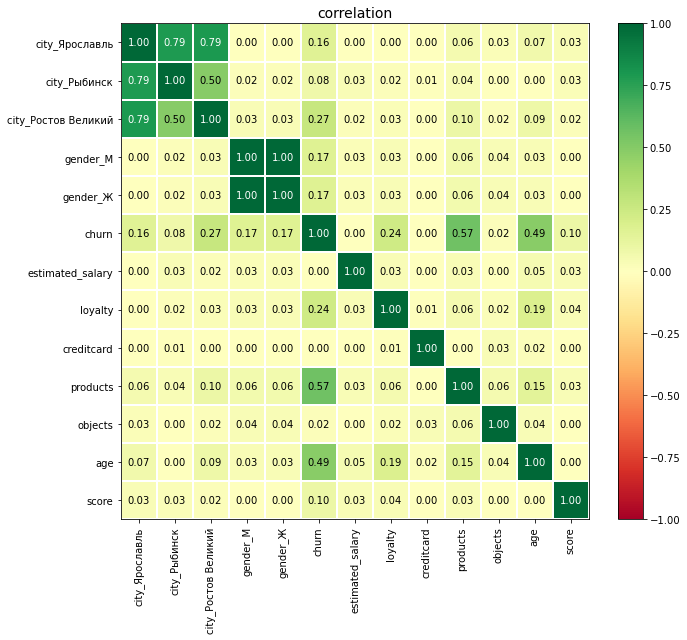

In [24]:
# Корреляция phik для всех переменных
phik_overview = df.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        figsize=(10, 9)
                       )
plt.tight_layout()

#### Выводы на основе матриц корреляции

За пределами рассматриваемых значений корреляции оттока с остальными признаками наблюдается некоторая связь возраста и лояльности (активности), а также возраста и количества продуктов. 

Наибольшая корреляция оттока наблюдается с возрастом и с количеством продуктов. Подтвердилась корреляция оттока и активности, а также интересно будет посмотреть на корреляцию оттока и города, оттока и пола клиента.


#### Изучение взаимосвязи возраста с активностью 

Изучим взаимосвязь возраста и лояльности в целом. Построим гистограмму без накопления для распределения признака - возраст.

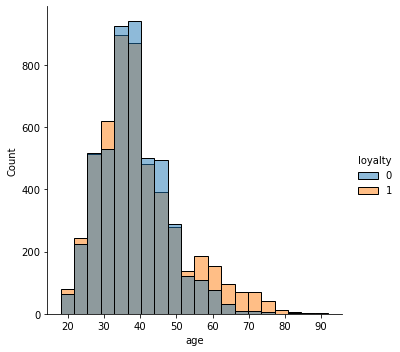

In [25]:
sns.displot(x='age',
         bins=20,
         hue='loyalty',       # разбивка цветом по дополнительному признаку, без накопления
         data=df)  
plt.show()


Не очевидный вывод. Примерно до 33-34 лет среди клиентов немного больше тех, кто проявляет свою активность, затем в возрастной категории от 34-35 лет до 50-52 общая активность снижается, а после 55 лет активных клиентов опять становится подавляющее большинство.  

#### Изучение взаимосвязи оттока с другими признаками по выделенным категориям клиентов (количеству продуктов)

На графиках ниже использованы цвета: blue - для тех, кто остались, orange - отток


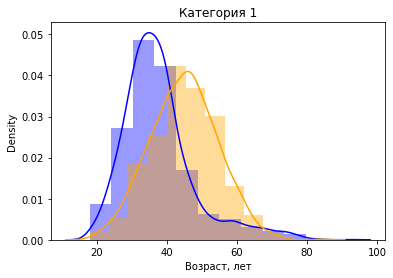

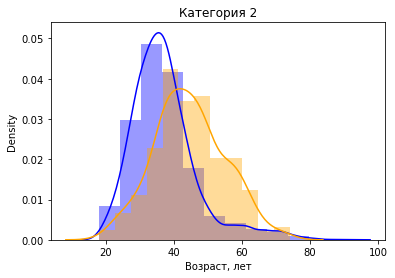

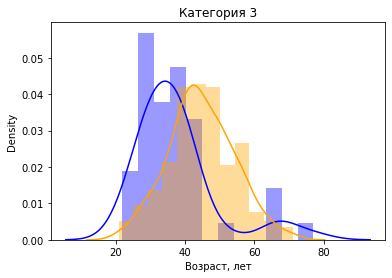

In [26]:
print('На графиках ниже использованы цвета: blue - для тех, кто остались, orange - отток')

for n in range(1, 4):  # В цикле построим графики для всех трех категорий
    
    sns.distplot(data.query('churn == 0 & category == @n')['age'], bins = 12, color='blue') 
    sns.distplot(data.query('churn == 1 & category == @n')['age'], bins = 12, color='orange')
    
    plt.xlabel('Возраст, лет')
    plt.title('Категория ' + str(n))
    plt.show()


#### Выводы по возрасту
В целом чем клиенты старше, тем более склонны к оттоку. В первой группе отток возрастает уже к 30 годам пользователей, во второй позже, к 40. 

Третья группа не очень показательна ввиду малочисленности, но в ней после 45 лет клиента практически все клиенты уходят, за исключением нескольких 65+.

С выводами по возрасту вообще надо быть осторожными, так как после определенной границы отток обуславливается естественными причинами (смертью).

**Выводы**

- В первом сегменте "в группу риска" попадают клиенты старше 30 лет. Доля оттока с увеличением возраста только растет.
- Во втором сегменте доля ушедших намного меньше, доля оттока увеличивается после 40 лет.
- Третий сегмент не показателен в плане возраста.

### Функция для вывода графиков по признакам

Опишем функцию для вывода графиков по какому-либо признаку, скоррелированному с оттоком, с делением по категориям клиентов.

In [27]:
# Определим функцию отрисовки графика по требуемому признаку    
def my_catplot(col_y, dat=data, x='category', hue='churn'):

    sns.catplot(               # используем catplot
        x, col=col_y, 
        col_wrap=3,            # не более 3х графиков в ряд  
        data=dat, hue=hue,
        kind='count',          # подсчет количества
        height=4, aspect=.8    # высота графиков и толщина столбцов
    )
    plt.show()   

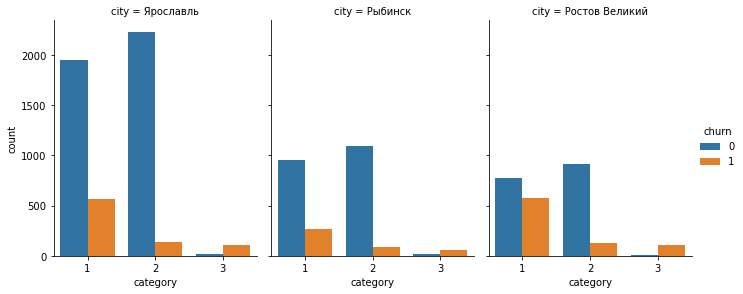

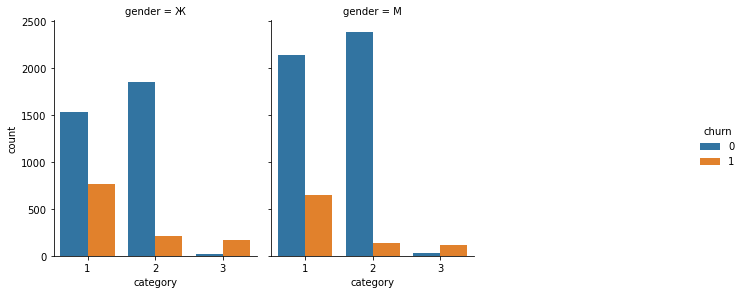

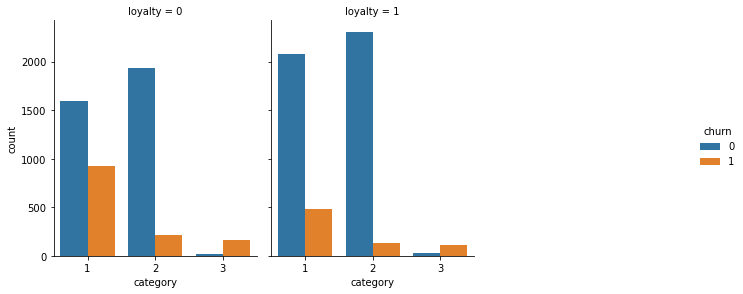

In [28]:
feature_list = ['city', 'gender', 'loyalty'] # список признаков на анализ
for feature in feature_list:
    my_catplot(feature)

#### Выводы по городу, полу, лояльности
По городам в целом: больше всего клиентов уходит в Ростове Великом, меньше в Рыбинске, меньше всего в Ярославле.

По городам и категориям:
- В первой категории отток в порядке убывания: Ростов (почти столько же, сколько отсталось), затем Ярославль и Рыбинск примерно в равных долях (треть от оставшихся). Отток во всех городах выше, чем для 2й категории.
- Во второй категории в порядке убывания: Ростов, Рыбинск, Ярославль. Наименьший отток среди трех групп.
- В третьей категории: Ростов, Ярославль, Рыбинск. В целом наибольший отток в процентном соотношении среди групп.

В зависимости от пола: 
- Отток мужчин меньше - не зависимо от категории (количества используемых продуктов).
- Наибольшая доля уходящих - среди женщин в первой категории, наименьшая - среди мужчин во второй. Третью категорию анализировать сложно ввиду малочисленности и практически поголовного оттока.  

По лояльности: 
- Меньше лояльность (активность) - больше отток.
- Наибольший отток среди 1 категории, не лояльных; наименьший - среди 2 категории + активных клиентов.

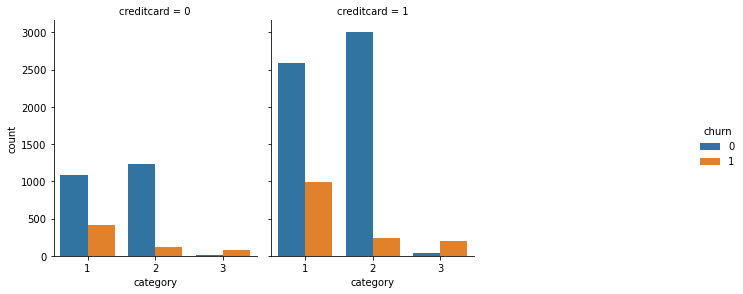

In [29]:
my_catplot('creditcard') # отдельно посмотрим признак - есть кредитная карта

Отдельно хотелось проверить гипотезу об иной долее оттока (большей или меньшей) владельцев единственного продукта - кредитной карты. Тепловая карта давала ничтожно малый коэффициент корреляции (ноль или 0,03) для пар кредитка - отток и кредитка - количество продуктов. И из гистограмм очевидно, что нет никакой разницы, является ли единственным продуктом кредитная карта, или есть помимо нее еще что-либо. Учтем это при дальнейших рекомендациях и не будем каким-либо образом акцентировать внимание именно на этом продукте.

##  Проверка статистических гипотез

Сформулируем гипотезы и проверим их методами статистического анализа.

### Гипотеза №1. Доход клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, отличается

Сначала проверим, подходят ли наши выборки для проверки статистических гипотез. Проведем анализ на предмет выбросов. Найдем, на сколько отличается количество пользователей в группах.

Для начала изучим распределение предполагаемого дохода ('estimated_salary').

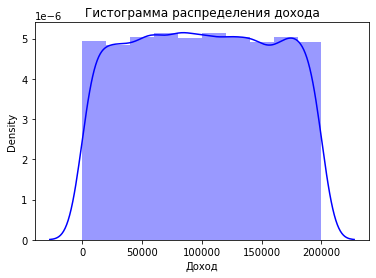

In [30]:
sns.distplot(data['estimated_salary'], bins = 10, color='blue')

plt.xlabel('Доход')
plt.title('Гистограмма распределения дохода')    
plt.show()

Не похоже, что мы имеем дело с нормально распределенными данными. Посмотрим на выбросы.

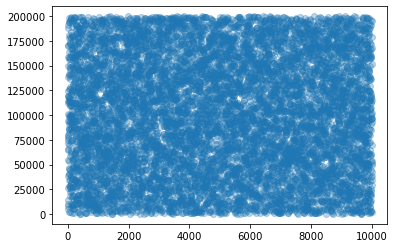

In [31]:
x_values = pd.Series(range(0,len(data['estimated_salary'])))
plt.scatter(x_values, data['estimated_salary'], alpha = 0.3) 
plt.show()

Выбросов не наблюдается, о том же говорят и статистические данные по этому столбцу (квартили распределены равномерно, среднее арифметическое очень близко к медианному значению). 

In [32]:
print('Отношение размеров групп:', len(data.query('category == 1')) / len(data.query('category == 2')))

Отношение размеров групп: 1.1076252723311546


Сформулируем гипотезы:
- H0: Нет статистической значимости различий между уровнями признака дохода в рассматриваемых выборках (группах);
- H1: Есть статистическая значимость различий между уровнями признака дохода в рассматриваемых выборках.

Так как мы имеем дело со значениями, не подчиняющимися нормальному распределению, и с выборками, отличающимися по размеру, то для возможности отвержения нулевой гипотезы применим непараметрический критерий Манна-Уитни. Так как отклонение наблюдаемого значения от предполагаемого возможно в обе стороны (доход первой группы либо больше, либо меньше дохода второй), то альтернативная гипотеза является двусторонней. Учтем это, указав в критерии Манна-Уитни mannwhitneyu() параметр alternative='two-sided'.

In [33]:
alpha = 0.01  # Задали критический уровень статистической значимости

results = st.mannwhitneyu(
    data.query('category == 1')['estimated_salary'], 
    data.query('category == 2')['estimated_salary'],
    alternative='two-sided')  # Тест двусторонний

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.'
    ) 

p-значение:  0.4079566651927651
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.


Вывод о различии доходов сделать нельзя, так как статистически значимого отличия между группами при принятом уровне статистической значимости в 0.01 нет.

### Гипотеза №2. Возраст клиентов, ушедших из банка, и тех, кто остался, отличается

Выбросов по возрасту нет. Распределение возрастп подчиняется нормальному закону. Размер групп в данном случае не важен, так как используем двусторонний непараметрический критерий Манна-Уитни.

Сформулируем гипотезы:
- H0: Нет статистической значимости различий между уровнями признака "возраст" в рассматриваемых выборках (группах);
- H1: Есть статистическая значимость различий между уровнями признака "возраст" в рассматриваемых выборках.

In [34]:
alpha = 0.01  # Задали критический уровень статистической значимости

results = st.mannwhitneyu(
    data.query('churn == 0')['age'], 
    data.query('churn == 1')['age'],
    alternative='two-sided')  # Тест двусторонний

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.'
    ) 

p-значение:  3.2104014319371675e-230
Отвергаем нулевую гипотезу: разница статистически значима.


Даже при уровне статистической значимости 0,01 мы отвергаем нулевую гипотезу, то есть признаем, что разница в возрасте среди ушедших и среди оставшихся статистически значима. Это подтверждает выводы на основе гистограмм из п. 4.2.4, что более молодые остаются чаще.

### Гипотеза №3. Баллы кредитного скоринга клиентов, пользующихся двумя продуктами банка, и тех, кто пользуется одним, отличаются

Выбросов, согласно статистическим данным, нет. Аналогично предыдущим проверкам гипотез, используем критерий Манна-Уилка.

Гипотезы:
- H0: Нет статистической значимости различий между уровнями признака "баллы кредитного скоринга" в рассматриваемых выборках (группах);
- H1: Есть статистическая значимость различий между уровнями признака "баллы кредитного скоринга" в рассматриваемых выборках.

In [35]:
alpha = 0.01  # Задали критический уровень статистической значимости

results = st.mannwhitneyu(
    data.query('category == 1')['score'], 
    data.query('category == 2')['score'],
    alternative='two-sided')  # Тест двусторонний

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.'
    ) 

p-значение:  0.15729739033138807
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.


Да, как и показали ранее матрицы корреляции, баллы кредитного скоринга при уровне статистической значимости в 0,01 статистически значимых отличий в группах не имеют.

### Выводы по проверкам статистических гипотез

- Нет статистически значимой разницы в распределении признака между группой А и В. (Оцененный доход клиентов и баллы кредитного скоринга среди выделенных сегментов клиентов банка - имеющих один или два банковских продукта- не имеют статистически значимых отличий). 

- Возраст клиента имеет статистическую значимость при оттоке. 

### Итак, имеем:

- Клиенты, имеющие два банковских продукта в своем распоряжении, уходят реже, чем те, у кого только один продукт или 3-4. Поэтому основной задачей должно стоять предложение второго банковского продукта тем, у кого уже есть один, так как данный сегмент клиентов наиболее многочисленен, но склонен к оттоку.
- Потеря лояльности (активности клиента) довольно тесно связана с оттоком, поэтому менеджерам желательно поддерживать активность клиента, привлекая его внимание в случае отсутствия действий в принятый срок какими-либо предложениями нового продукта (что особенно актуально для первого сегмента, то есть имеющих всего один продукт) либо изменениями условий или бонусами (актуальнее для второго сегмента, чтобы не увеличивать число продуктов). 
- Особое внимание следует уделять клиентам старше 30 лет (для первого сегмента) и 40 лет (для второго сегмента), причем чем старше клиент, тем внимательнее к нему относиться, так как с увеличением возраста клиента возрастает вероятность его оттока.
- Для тех клиентов, у кого продуктов уже 3 или 4, можно было бы попытаться вносить предложения снизить число продуктов до двух, но, ввиду малочисленности данного сегмента клиентов (всего около 3%) и отсутствия на данный момент информации о технической возможности, данная рекомендация может не выполняться или выполняться в последнюю очередь.


## Выводы и рекомендации в зависимости от сегмента клиента

Общая стратегия. Коммуникация, активизирующая действия клиентов, увеличивает вероятность удержания. 
Активизировать действия клиентов и предотвратить снижение вовлеченности можно звонками, письмами (рассылками) с предложениями, бонусами, эксклюзивными и персонализированными предложениями вне привязки к праздничным датам или даже просто письмами, например, к дню рождения. Особенно актуально повысить качество обслуживания и лояльность в городах Ростов Великий и Рыбинск, так как там отток больше, чем в отделениях Ярославля. Имеет смысл дополнительно уделять внимание клиентам старше 35 лет, повышая их информированность о продуктах и услугах.

В целом, в зоне риска находятся клиенты, имеющие один признак или их сочетание из следующих: имеющие всего один банковский продукт, проживающие в городах Ростов Великий или Рыбинск, возраста 35-50 лет, преимущественно женщины. Портрет наименее склонного к оттоку клиента: молодой мужчина из Ярославля, активно пользующийся двумя продуктами банка. Противоположность - женщина из Ростова после 40 лет с одним банковским продуктом.

Так как привлечение нового клиента обходится в несколько раз дороже, чем удержание старого, на основе проведенного исследования можно попытаться составить ряд предложений, способных удержать клиентов на длительной перспективе.

Для уже имеющих два и более продукта не стоит активно предлагать новые карты или кредиты, но можно постараться предложить продукты на долгосрочные контракты (накопительные или инвестиционные счета); при достаточно большом балансе или количестве имеющихся в собственности объектов - сейфовые ячейки; для всех уровней дохода - кэшбэк и бонусы. В зависимости от баллов скоринга можно предложить кредит наличными или оформление ипотеки.

Для тех, у кого пока имеется только один банковский продукт, выбор предложений намного шире. Можно предложить, например, вторую карту, отличную от имеющейся (дебетовую или кредитную), при имеющейся дебетовой карте открыть накопительный или инвестиционный счет. Преимущественно при небольшом количестве объектов в собственности (до 3-4) - предлагать ипотечный кредит или кредит наличными на покупку. Кэшбэк, бонусы обязательны к предложению всем клиентам.

Прочие меры по повышению лояльности клиентов находятся в ведении отдела маркетинга. Аналитик данных всегда готов провести исследования и подтвердить или отвергнуть гипотезу об эффективности проведенных мероприятий по удержанию клиентов. 

## Визуальные материалы

* [Дашборд](https://public.tableau.com/app/profile/nadezhda8107/viz/dash_banks/Dashboard1)
* [Презентация](https://disk.yandex.ru/i/jNO2zXmc9NKrAg)